#### General Problem with Outliers  

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
import matplotlib as mpl
from sklearn.linear_model import  LinearRegression

In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')

input data shape:  (40,)
y shape:  (40,)
fit coeff and intercept:  [[1.55563293]] [-2.25689158]
fit coeff and intercept without outlier:  [[0.69967854]] [-2.01453401]


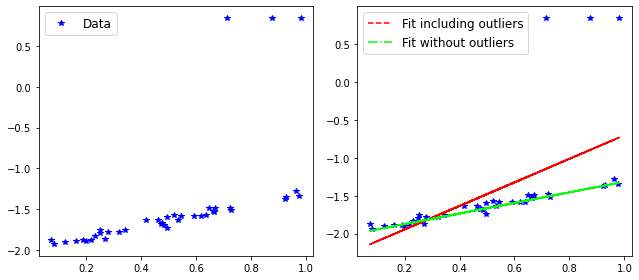

In [ ]:
x = np.random.uniform(size=40)
print ('input data shape: ', x.shape)
check_slope = 0.7 
intercept = -2

y = (x * check_slope) + intercept + np.random.normal(scale=0.05, size=40) 
print ('y shape: ', y.shape)

flip_mask = np.random.uniform(size=40) > 0.9
y = np.where(flip_mask, 0.05 + 0.4 * (1. - np.sign(y - 0.2)), y)
y_no_outlier = (x * check_slope) + intercept + np.random.normal(scale=0.05, size=40)

x_reshaped = x.reshape(-1, 1)
y_reshaped = y.reshape(-1, 1)
y_n_outlier_reshaped = y_no_outlier.reshape(-1, 1)

reg = LinearRegression().fit(x_reshaped, y_reshaped)
reg1 = LinearRegression().fit(x_reshaped, y_n_outlier_reshaped)

print ('fit coeff and intercept: ', reg.coef_, reg.intercept_)
print ('fit coeff and intercept without outlier: ', reg1.coef_, reg1.intercept_)

fitted_y = x * reg.coef_[0][0] + reg.intercept_[0]
fitted_y_n_outlier = x * reg1.coef_[0][0] + reg1.intercept_[0]

fig = plt.figure(figsize=(9, 4))
fig.add_subplot(121)
plt.plot(x, y, linestyle='None', marker='*', color='blue', label='Data')
plt.legend(fontsize=12)
fig.add_subplot(122)
plt.plot(x, y, linestyle='None', marker='*', color='blue', )
plt.plot(x, fitted_y, linestyle='--', color='red', label='Fit including outliers')
plt.plot(x, fitted_y_n_outlier, linestyle='-.', color='lime', label='Fit without outliers')
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('/content/gdrive/My Drive/Colab Notebooks/outlier.png', dpi=170)

We see the problem above, how the fit line getting influenced by the outliers than the inliers. This is mainly due to the quadrati nature of the MSE loss. We need robust loss like MAE to address this type of problem. Since there are different types of robust losses depending upon the problem we may need to try different robust losses. The idea is to find a loss function where the loss function itself can adjust depending on the problem and transition between different losses becomes smooth. This trainsition can be controlled by a hyperparameter. Let's see below--  

## Adaptive Loss Function 


[Main Paper](https://arxiv.org/pdf/1701.03077.pdf) by Jon Barron.  

General form of loss function: 

$f(x, \alpha , c) = \frac{|\alpha -2|}{\alpha} \left(\left( \frac{(x/c)^2}{|\alpha -2|} + 1 \right)^{\frac{\alpha}{2}} - 1 \right)$, 

where $\alpha \in \mathbb{R}$ is a shape parameter that controls the robustness of the loss and $c > 0$ is a scale parameter that controls the size of the loss's quadratic bowl near $x=0$.      

The Loss Function $f(x, \alpha , c)$ can be approximated for  several specific values of $\alpha$ as below -- 

----------

$ 0.5\, \left(\frac{x}{c}\right)^2;\, \text{for}\, \text{limit}\, \alpha \rightarrow 2$; L2 Loss

$\sqrt{\left(\frac{x}{c} \right)^2 +1 } - 1; \, \text{for}\, \alpha = 1$; L1 Loss. 


$\text{log}\, \left(\left(\frac{x}{c}\right)^2 + 1\right) ;\,  \text{for}\, \text{limit}\, \alpha \rightarrow 0 $; Cauchy Loss.  

$\frac{2\, \left(\frac{x}{c}\right)^2}{ \left(\frac{x}{c}\right)^2 + 4}; \,  \text{for}\, \alpha = -2$; Geman-McClure Loss.   

$1-\text{exp}\, \left(-0.5\left(\frac{x}{c}\right)^2 \right);\,  \text{for}\, \text{limit}\, \alpha \rightarrow -\infty$; Welsch Loss. 

-------------

For Gradient Based optimization, the derivative of the adaptive loss w.r.t $x$ i.e. $\frac{\partial f}{\partial x} (x, \alpha , c)$, for different values of $\alpha$ are as follows-- 

$\frac{\partial f}{\partial x}(x, \alpha, c)$ for various $\alpha$--

$\frac{x}{c^2};\,    \text{for}\, \alpha = 2 $

$\frac{2x}{x^2 + 2c^2}; \, \text{for}\, \alpha = 0 $

$\frac{x}{c^2}\, \text{exp}\, \left(-0.5\left(\frac{x}{c}\right)^2 \right); \,   \text{for}\, \alpha =-\infty $

$\frac{x}{c^2}\, \left(\frac{(x/c)^2}{|\alpha - 2|} + 1 \right)^{\left(\frac{\alpha}{2} -1 \right)}; $ otherwise. 



In [ ]:
# x = np.random.uniform(-0.6, 0.6, 100)
# plt.hist(x, density=True, bins=int(np.sqrt(len(x))) )

x = np.linspace(-5.7, 5.7, 150)
y = np.linspace(-5.7, 5.7, 150)

In [ ]:
def adap_loss(alpha, c, x):
  if alpha==2.0 :
    return 0.5 * (x/c)**2
  elif alpha==0.0:
    return math.log(( 0.5 * (x/c)**2 ) + 1)  
  else:   
    first = abs( alpha - 2. ) / alpha
    second = ( ( ( (x/c)**2 ) / abs(alpha-2) ) +1 ) ** (alpha/2)
    third = second -1.  
    final = first * third 
    return final 

def grad_adap_loss(alpha, c, x): 
  # grad of adaptive loss 
  if alpha==2.0 :
    return (x/c**2)
  elif alpha==0.0:
    return (2*x)/(x**2 + 2*c**2)
  else:
    first = x/(c**2)    
    second = ( ( ( (x/c)**2 ) / abs(alpha-2) )  + 1 ) ** (alpha/2 -1)
    final = first * second
    return final 

In [ ]:
loss0 = []
grad_loss0 = []
loss1 = []
grad_loss1 = []
loss2 = []
grad_loss2 = []
loss3 = []
grad_loss3 = []
loss4 = []
grad_loss4 = []
loss5 = []
grad_loss5 = []

alpha = [-2.0, 0., 0.5, 1, 1.5, 2.0]
c = 1.1
for i in range(len(x)):
  l0 = adap_loss(alpha[0], c, x[i])
  gl0 = grad_adap_loss(alpha[0], c, x[i])
  l1 = adap_loss(alpha[1], c, x[i])
  gl1 = grad_adap_loss(alpha[1], c, x[i])
  l2 = adap_loss(alpha[2], c, x[i])
  gl2 = grad_adap_loss(alpha[2], c, x[i])
  l3 = adap_loss(alpha[3], c, x[i])
  gl3 = grad_adap_loss(alpha[3], c, x[i])
  l4 = adap_loss(alpha[4], c, x[i])
  gl4 = grad_adap_loss(alpha[4], c, x[i])
  l5 = adap_loss(alpha[5], c, x[i])
  gl5 = grad_adap_loss(alpha[5], c, x[i])

  loss0.append(l0)
  grad_loss0.append(gl0)
  loss1.append(l1)
  grad_loss1.append(gl1)
  loss2.append(l2)
  grad_loss2.append(gl2)
  loss3.append(l3)
  grad_loss3.append(gl3)
  loss4.append(l4)
  grad_loss4.append(gl4)
  loss5.append(l5)
  grad_loss5.append(gl5)

In [ ]:
print ('check loss: ', len(loss1))

check loss:  150


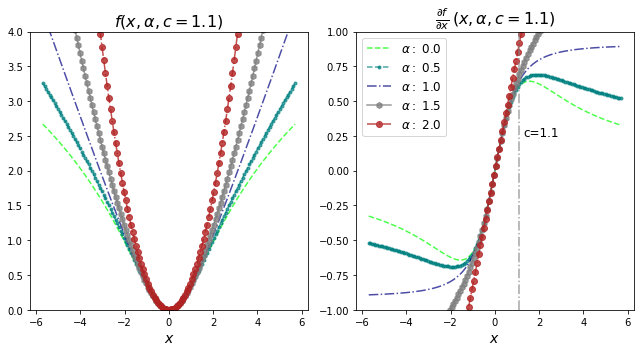

In [ ]:
fig = plt.figure(figsize=(9, 5))

# plt.yscale('log')
fig.add_subplot(121)
plt.ylim(0, 4)

# plt.plot(x, (loss0), linestyle='--', marker='*', color='red', 
        #  alpha=0.7, label=r'$\alpha :$ %1.1f'%(alpha[0]))

plt.plot(x, loss1, linestyle='--', linewidth = 1.5, color='lime', 
         alpha=0.7, label=r'$\alpha :$ %1.1f'%(alpha[1]))

plt.plot(x, loss2, linestyle='--', marker='.', color='teal', 
         alpha=0.7, label=r'$\alpha :$ %1.1f'%(alpha[2]) )

plt.plot(x, loss3, linestyle='-.',  linewidth = 1.5, color='navy', 
         alpha=0.7, label=r'$\alpha :$ %1.1f'%(alpha[3]) )

plt.plot(x, loss4, linestyle='-', marker='h', color='gray', 
         alpha=0.8, label=r'$\alpha :$ %1.1f'%(alpha[4]) )

plt.plot(x, loss5, linestyle='-.', marker='o', color='firebrick', 
         alpha=0.8, label=r'$\alpha :$ %1.1f'%(alpha[5]) )

plt.xlabel(r'$x$', fontsize=14)

plt.title(r'$f(x, \alpha , c = 1.1)$', fontsize=16)



fig.add_subplot(122)
plt.ylim(-1, 1)
# plt.plot(x, (grad_loss0), linestyle='--', marker='*', color='red', 
        #  alpha=0.7, label=r'$\alpha :$ %1.1f'%(alpha[0]))

plt.plot(x, (grad_loss1), linestyle='--', linewidth = 1.5, color='lime', 
         alpha=0.7, label=r'$\alpha :$ %1.1f'%(alpha[1]))

plt.plot(x, grad_loss2, linestyle='--', marker='.', color='Teal', 
         alpha=0.7, label=r'$\alpha :$ %1.1f'%(alpha[2]) )

plt.plot(x, grad_loss3, linestyle='-.', linewidth = 1.5, color='navy', 
         alpha=0.7, label=r'$\alpha :$ %1.1f'%(alpha[3]) )

plt.plot(x, grad_loss4, linestyle='-', marker='h', color='gray', 
         alpha=0.8, label=r'$\alpha :$ %1.1f'%(alpha[4]) )

plt.plot(x, grad_loss5, linestyle='-.', marker='o', color='firebrick', 
         alpha=0.8, label=r'$\alpha :$ %1.1f'%(alpha[5]) )

plt.axvline(x=1.1, color='grey', alpha=0.7, linestyle='-.')
plt.text(1.3, 0.25, 'c=1.1', fontsize=12)

plt.title(r'$\frac{\partial f}{\partial x}\, (x, \alpha , c = 1.1)$', fontsize=16)
# plt.legend()
plt.xlabel(r'$x$', fontsize=14)

plt.legend(fontsize=12)
plt.tight_layout()

plt.savefig('/content/gdrive/My Drive/Colab Notebooks/adaptiveloss.png', dpi=160)
plt.show()

In [ ]:
### plot the surfaces 

def adap_loss3D(alpha, c, x, y):
  if alpha==2.0 :
    return 0.5 * ( (x/c)**2 + (y/c)**2 )
  elif alpha==0.0:
    return np.log( ( 0.5 * ( (x/c)**2  + (y/c)**2 ) ) + 1)  
  else:   
    first = abs( alpha - 2. ) / alpha
    # second = ( ( ( ( (x+y) / c )**2 ) / abs(alpha-2) ) +1 ) ** (alpha/2)
    second = ( ( ( ( x / c )**2 + (y / c)**2 ) / abs(alpha-2) ) +1 ) ** (alpha/2)
    third = second -1.  
    final = first * third 
    return final

def grad_adap_loss3D(alpha, c, x, y): 
  # grad of adaptive loss 
  if alpha==2.0 :
    return ( (x+y) / c**2)
  elif alpha==0.0:
    return (2* (x+y))/(x**2 + y**2 + 2*c**2)
  else:
    first = (x+y)/(c**2)    
    second = ( ( ( ( x / c )**2  + ( y / c)**2 ) / abs(alpha-2) )  + 1 ) ** (alpha/2 -1)
    final = first * second
    return final     

In [ ]:
X, Y = np.meshgrid(x, y)

c = 1.1

Z00 = adap_loss3D(0.0, c, X, Y)
Z0  = adap_loss3D(1.5, c, X, Y) 
Z   = adap_loss3D(0.5, c, X, Y)
Z1  = adap_loss3D(1.0, c, X, Y)
Z2  = adap_loss3D(2.0, c, X, Y)

Z00_grad = grad_adap_loss3D(0.0, c, X, Y)
Z0_grad  = grad_adap_loss3D(1.5, c, X, Y)
Z_grad   = grad_adap_loss3D(0.5, c, X, Y)
Z1_grad  = grad_adap_loss3D(1.0, c, X, Y)
Z2_grad  = grad_adap_loss3D(2.0, c, X, Y)

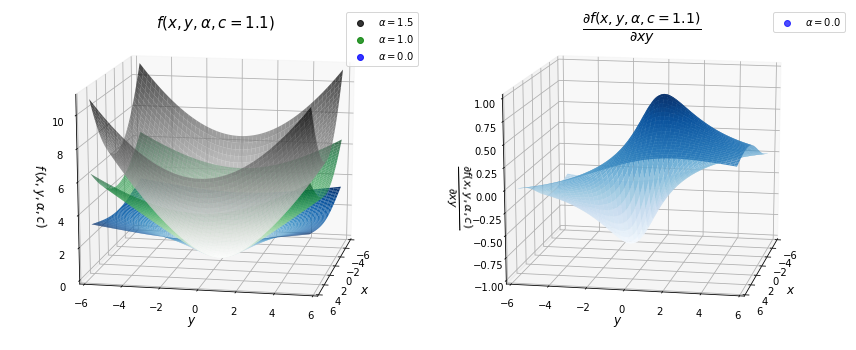

In [ ]:
from mpl_toolkits import mplot3d
# fig = plt.figure(figsize=plt.figaspect(0.4))
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(121, projection = '3d')

ax.view_init(15, 11)


ax.plot_surface(X, Y, Z00, cmap='Blues', label=r'\alpha = 0.0')
ax.plot_surface(X, Y, Z1, cmap='Greens', alpha = 0.7, label=r'\alpha = 1.0' )
ax.plot_surface(X, Y, Z0, cmap='Greys', alpha=0.7, label=r'\alpha = 1.5')
# ax.plot_surface(X, Y, Z2, cmap='Purples', alpha = 0.7, label=r'\alpha = 2.0')

ax.set_xlabel(r'$x$', fontsize=12)
ax.set_ylabel(r'$y$', fontsize=12)
ax.set_zlabel(r'$f\, (x, y, \alpha , c)$', fontsize=12)

ax.set_xlim3d(-6.0, 6.0)
ax.set_ylim3d(-6.0, 6.0)
ax.set_zlim3d(0, 11)



# fake2Dline = mpl.lines.Line2D([0],[0], linestyle="none", color='purple', marker='o', alpha=0.7)
fake2Dline1 = mpl.lines.Line2D([0],[0], linestyle="none", color='black', marker='o', alpha=0.8)
fake2Dline2 = mpl.lines.Line2D([0],[0], linestyle="none", color='green', marker='o', alpha=0.8)
fake2Dline3 = mpl.lines.Line2D([0],[0], linestyle="none", color='blue', marker='o', alpha=0.8)

ax.legend([ fake2Dline1, fake2Dline2, fake2Dline3 ], [r'$\alpha = 1.5$', r'$\alpha = 1.0$', r'$\alpha = 0.0$'], numpoints = 1)
ax.set_title(r'$f(x, y, \alpha , c=1.1)$', fontsize=15)

ax = fig.add_subplot(122, projection='3d')
ax.view_init(15, 11)

ax.plot_surface(X, Y, Z00_grad, cmap='Blues', alpha = 0.9, label=r'\alpha = 0.0' )

# ax.plot_surface(X, Y, Z1_grad, cmap='plasma', alpha = 0.7, label=r'\alpha = 1.0' )
# ax.plot_surface(X, Y, Z0_grad, cmap='Greys', alpha = 0.7, label=r'\alpha = 1.5')
# ax.plot_surface(X, Y, Z2_grad, cmap='Purples', label=r'\alpha = 2.0')

fake2Dline_grad = mpl.lines.Line2D([0],[0], linestyle="none", color='blue', marker='o', alpha=0.7)
ax.legend([fake2Dline_grad], [ r'$\alpha = 0.0$' ], numpoints = 1)


ax.set_xlabel(r'$x$', fontsize=12)
ax.set_ylabel(r'$y$', fontsize=12)
ax.set_zlabel(r'$\frac{\partial f(x, y, \alpha , c)}{\partial xy}$', fontsize=16, labelpad=8.9)

ax.set_xlim3d(-6.0, 6.0)
ax.set_ylim3d(-6.0, 6.0)
ax.set_zlim3d(-1., 1.)

ax.set_title(r'$\frac{\partial f(x, y, \alpha , c=1.1)}{\partial xy}$', fontsize=20, loc='center', pad=0.1)
fig.tight_layout()
fig.savefig('/content/gdrive/My Drive/Colab Notebooks/adaptiveloss_surface.png', dpi=160)


Few important points related to the Cost Function: 

1. When the residual is less $(|x|< c)$, then the derivative is proportional to the residual itself. 
2. Specifically when $\alpha = 2$, the derivatives magnitude remains proportional to the residual. 
3. For $\alpha = 1$, as residual increases $\left(\frac{\partial f}{\partial x} = \frac{x}{c^2} \left(\frac{x^2}{c^2} + 1\right)^{-1/2}\right)$, it saturates to a constant $\frac{1}{c}$. So as $|x|$ grows larger than $c$ the magnitude of the derivative increases but never exceeds a certain value. 
4. From the plot we also see that the magnitude of the derivative decreases as residual ($x$) increases beyond $c$, when $\alpha < 1$. This implies that as the residual increases for an outlier, the derivative for that will have less effect during gradient descent. 
5. Since the loss function is smooth it is well suited for grad based optimization. 
6. The loss is zero at origin and increases monotonically with respect to $|x|$. 
7. The loss also monotonically increases w.r.t. to $\alpha$, i.e. $\frac{\partial f}{\partial \alpha}\geq 0$. Thus it is possible to initialize $\alpha$ such that loss is convex and gradually reduce $\alpha$ during optimization. This helps us to avoid local minima.         

In [ ]:
# !pip install git+https://github.com/jonbarron/robust_loss_pytorch

In [ ]:
# !pip install celluloid

In [ ]:
import robust_loss_pytorch
from celluloid import Camera

In [ ]:
import numpy as np
import torch 
import matplotlib.pyplot as plt

# Construct some regression data with some extreme outliers.
np.random.seed(20)
n = 50
scale_true = 0.7
shift_true = 0.15
x = np.random.uniform(size=n)
y = scale_true * x + shift_true
y = y + np.random.normal(scale=0.025, size=n)
flip_mask = np.random.uniform(size=n) > 0.9
y = np.where(flip_mask, 0.05 + 0.4 * (1. - np.sign(y - 0.5)), y)

x = torch.Tensor(x)
y = torch.Tensor(y)

class RegressionModel(torch.nn.Module): 
    # A simple linear regression module.
    def __init__(self): 
        super(RegressionModel, self).__init__() 
        self.linear = torch.nn.Linear(1, 1)  
        # weight = self.linear.bias
        # print ('check weight', weight)
    def forward(self, x): 
        return self.linear(x[:,None])[:,0]

def plot_regression(regression, losstype):
    # A helper function for plotting a regression module.
    x_plot = np.linspace(0, 1, 100)
    y_plot = regression(torch.Tensor(x_plot)).detach().numpy()
    y_plot_true = x_plot * scale_true + shift_true

    plt.figure(figsize=(7,5))
    plt.scatter(x, y, color='red', label='Original Data', alpha=0.6)
    plt.plot(x_plot, y_plot_true, linestyle='-.', color='grey', label='True Line')
    plt.plot(x_plot, y_plot, linestyle='--', color='lime', alpha=0.7, label='{0}'.format(str(losstype)))
    plt.legend(fontsize=12)

#### General Loss ($\alpha$ is user input & _Constant_)

For better understanding check the [general.py](https://github.com/jonbarron/robust_loss_pytorch/blob/master/robust_loss_pytorch/general.py) part of the main code.  

check weight Parameter containing:
tensor([0.8106], requires_grad=True)
0   : loss=8.671177
100 : loss=2.327991
200 : loss=1.993630
300 : loss=1.963238
400 : loss=1.962221
500 : loss=1.962208
600 : loss=1.962208
700 : loss=1.962208
800 : loss=1.962208
900 : loss=1.962208
1000: loss=1.962208
1100: loss=1.962208
1200: loss=1.962208
1300: loss=1.962208
1400: loss=1.962208
1500: loss=1.962208
1600: loss=1.962208
1700: loss=1.962208
1800: loss=1.962208
1900: loss=1.962208


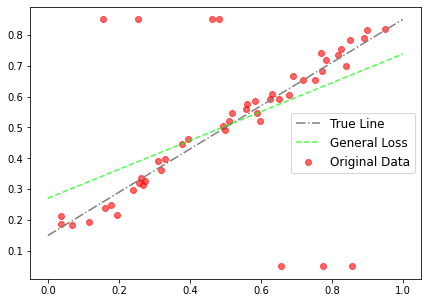

In [ ]:
# Fit a linear regression using mean squared error.
regression = RegressionModel() 
params = regression.parameters()
optimizer = torch.optim.Adam(params, lr = 0.01) 

for epoch in range(2000): 

    y_i = regression(x) 
    
    # Use general loss to compute MSE, fixed alpha, fixed scale.
    loss = torch.mean(robust_loss_pytorch.general.lossfun(
        y_i - y, alpha=torch.Tensor([2.]), scale=torch.Tensor([0.1])))

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if np.mod(epoch, 100) == 0:
        print('{:<4}: loss={:03f}'.format(epoch, loss.data)) 

# Bad fit.
plot_regression(regression, 'General Loss')

#### Adaptive loss ($\alpha$ varies)

check weight Parameter containing:
tensor([0.2499], requires_grad=True)
0   : loss=1.214950  alpha=1.004995  scale=0.993690
100 : loss=0.434395  alpha=1.454305  scale=0.475444
200 : loss=-0.178994  alpha=1.688660  scale=0.213873
300 : loss=-0.280343  alpha=1.606426  scale=0.152267
400 : loss=-0.393623  alpha=1.169621  scale=0.118562
500 : loss=-0.690293  alpha=0.533214  scale=0.066182
600 : loss=-1.038846  alpha=0.196745  scale=0.031000
700 : loss=-1.170476  alpha=0.091159  scale=0.019707
800 : loss=-1.199688  alpha=0.055102  scale=0.016744
900 : loss=-1.209253  alpha=0.039064  scale=0.015827
1000: loss=-1.212723  alpha=0.030230  scale=0.015450
1100: loss=-1.216524  alpha=0.024630  scale=0.015250
1200: loss=-1.218285  alpha=0.020743  scale=0.015124
1300: loss=-1.219193  alpha=0.017874  scale=0.015039
1400: loss=-1.220462  alpha=0.015664  scale=0.014969
1500: loss=-1.221179  alpha=0.013906  scale=0.014923
1600: loss=-1.221755  alpha=0.012472  scale=0.014878
1700: loss=-1.222220  alpha=0

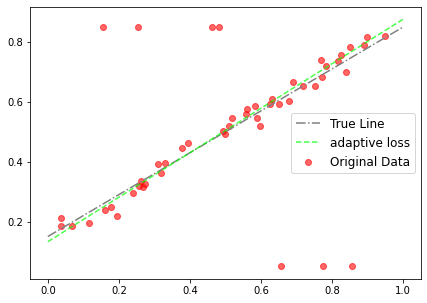

In [ ]:
# Fit a linear regression, and the parameters of an adaptive loss.
regression = RegressionModel() 
adaptive = robust_loss_pytorch.adaptive.AdaptiveLossFunction(
    num_dims = 1, float_dtype=np.float32, device='cpu')
params = list(regression.parameters()) + list(adaptive.parameters())
optimizer = torch.optim.Adam(params, lr = 0.01) 

for epoch in range(2000): 

    y_i = regression(x) 
    
    loss = torch.mean(adaptive.lossfun((y_i - y)[:,None]))

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if np.mod(epoch, 100) == 0:
        # You can see the alpha+scale parameters moving around.
        print('{:<4}: loss={:03f}  alpha={:03f}  scale={:03f}'.format(
            epoch, loss.data, adaptive.alpha()[0,0].data, adaptive.scale()[0,0].data)) 

plot_regression(regression, 'adaptive loss')

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive') 

In [ ]:
# !apt install imagemagick

#### Animate the Fit Line 

In [ ]:

def just_regression_ani(regression):
    # A helper function for plotting a regression module.
    x_plot = np.linspace(0, 1, 100)
    y_plot = regression(torch.Tensor(x_plot)).detach().numpy()
    y_plot_true = x_plot * scale_true + shift_true
    return x_plot, y_plot, y_plot_true




# Fit a linear regression, and the parameters of an adaptive loss.
regression = RegressionModel() 
adaptive = robust_loss_pytorch.adaptive.AdaptiveLossFunction(
    num_dims = 1, float_dtype=np.float32, device='cpu')
params = list(regression.parameters()) + list(adaptive.parameters())
optimizer = torch.optim.Adam(params, lr = 0.01) 


# x_plot = np.linspace(0, 1, 100)
# y_plot = regression(torch.Tensor(x_plot)).detach().numpy()
# y_plot_true = x_plot * scale_true + shift_true

fig = plt.figure(figsize=(7, 5))
camera = Camera(fig)



for epoch in range(2000): 

    y_i = regression(x) 
    
    loss = torch.mean(adaptive.lossfun((y_i - y)[:,None]))

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if np.mod(epoch, 50) == 0:
      print('{:<4}: loss={:03f}  alpha={:03f}  scale={:03f}'.format(
        epoch, loss.data, adaptive.alpha()[0,0].data, adaptive.scale()[0,0].data))
      # print ("regression params: ", list(regression.parameters()) )
      # print ("adaptive params: ", list(adaptive.parameters() ))
      xp, yp, ypt = just_regression_ani(regression) 
      plt.plot(x, y, marker='o', markersize=4, linestyle='none', color='red', alpha=0.7)
      plt.plot(xp, ypt, linestyle='-.', color='grey', alpha=0.7)
      plt.plot(xp, yp, linestyle='--', color='lime', )
      plt.autoscale(tight=True)
      plt.gca().yaxis.set_major_locator(plt.NullLocator())
      label1 = ["Original Data", "True Line", "Fit Using Adaptive Loss"]
      # # if epoch==1599:
      # plt.legend(label1, fontsize=12)
      camera.snap()
      plt.legend(label1, fontsize=12)
      


animation = camera.animate(interval=10)
animation.save('/content/gdrive/My Drive/Colab Notebooks/adap_loss.gif', fps=2, writer = 'imagemagick', dpi=140)
plt.clf()


check weight Parameter containing:
tensor([0.7253], requires_grad=True)
0   : loss=1.269917  alpha=1.004995  scale=0.993690
50  : loss=0.879322  alpha=1.247669  scale=0.705134
100 : loss=0.453234  alpha=1.455157  scale=0.473440
150 : loss=0.046651  alpha=1.607385  scale=0.304873
200 : loss=-0.195223  alpha=1.686155  scale=0.205907
250 : loss=-0.260749  alpha=1.677030  scale=0.164360
300 : loss=-0.287853  alpha=1.575190  scale=0.148963
350 : loss=-0.334292  alpha=1.383889  scale=0.133965
400 : loss=-0.418107  alpha=1.097107  scale=0.112382
450 : loss=-0.554266  alpha=0.759736  scale=0.085493
500 : loss=-0.744077  alpha=0.470508  scale=0.059259
550 : loss=-0.936416  alpha=0.280825  scale=0.039641
600 : loss=-1.073922  alpha=0.174040  scale=0.027937
650 : loss=-1.145313  alpha=0.116326  scale=0.021855
700 : loss=-1.177954  alpha=0.084105  scale=0.018834
750 : loss=-1.193262  alpha=0.064884  scale=0.017310
800 : loss=-1.201499  alpha=0.052552  scale=0.016497
850 : loss=-1.206507  alpha=0.0

<Figure size 504x360 with 0 Axes>